In [ ]:
# If you are using Google Colab, uncomment the next line and run this cell to install pymatgen.

#!pip install pymatgen
from __future__ import annotations

# Introduction

Here, we will demonstrate the use of trees. For this work, we will be reusing our Lab 2 dataset. I will reiterate that cross-validation must be done to have any confidence in your ML models. At the very least, a proper training/test split should be done.

As we move towards the end of this course, we are going to be working with much more sophisticated tools in the scikit-learn package. Specifically, one of the things we will use extensively is [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). This class allows us to scan a set of parameter values for a model and return the CV results.

In [ ]:
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymatgen.core import Composition

rcparams = {
    "legend.fontsize": 20,
    "figure.figsize": (12, 8),
    "axes.labelsize": 24,
    "axes.titlesize": 28,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
}
sns.set(rc=rcparams)
mpl.rcParams.update(rcparams)

from sklearn.ensemble import (
    AdaBoostClassifier,
    AdaBoostRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, export_text

In [ ]:
# by default pandas will recognize NaN (sodium nitride) as nan (not a number)
# to turn off this behavior, we use na_filter=False
data_url = "https://raw.githubusercontent.com/materialsvirtuallab/nano281/master/lectures/notebooks/data.csv"
data = pd.read_csv(data_url, index_col=0, na_filter=False)

# Let's create a column of Composition objects using pymatgen.
data["composition"] = [Composition(f) for f in data["formula"]]

Here, we load the elemental data. Unlike lab2, we are simply going to disregard all elemental features that contain NaN. While imputing the mean value is a commonly used data science technique, it really does not work well for materials science problems. We will also use a smaller set of properties.

In [ ]:
el_data_url = (
    "https://raw.githubusercontent.com/materialsvirtuallab/nano281/master/lectures/notebooks/element_properties.csv"
)
el_data = pd.read_csv(el_data_url, index_col=0)
el_data = el_data[["AtomicRadius", "AtomicWeight", "Column", "Electronegativity", "Row"]]

As before, we will compute the mean, min, and max for every elemental feature. For mean, we are weighting it by composition. As before, we drop all data points that contain NaN.

In [ ]:
props = collections.defaultdict(list)

for comp in data["composition"]:
    for c in el_data.columns:
        vals = [el_data[c][el.symbol] for el, amt in comp.items()]
        comp_vals = [el_data[c][el.symbol] * amt for el, amt in comp.items()]
        props[f"{c}Mean"].append(sum(comp_vals) / comp.num_atoms)
        props[f"{c}Min"].append(min(vals))
        props[f"{c}Max"].append(max(vals))
data = data.assign(**props)
data = data.dropna()
print(data.shape)

(124342, 21)


We are left with around 106k data points, Still more than enough for our purposes. Let's create our features and targets.

In [ ]:
features = [c for c in data.columns if c.endswith(("Mean", "Min", "Max"))]
x = data[features]
y_class = [0 if bg < 1e-4 else 1 for bg in data["band_gap"]]
y_reg = data["band_gap"]

Before we proceed further, let us write up some reusable methods to standardize the analysis of different ML models. Copy and pasting code is fine for earlier demos to reiterate the API of scikit-learn, but it is very bad programming practice. By this stage of the course, we want to do things better.

In [ ]:
def plot_grid_search_results(gs, ylim=None):
    """
    Plots the results of GridSearchCV.

    Args:
        gs: A GridSearchCV object.
        ylim: Optional setting for y limits.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    fig, ax = plt.subplots(figsize=(16, 8))
    ax = sns.lineplot(x=x, y="mean_train_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_train_score", data=results, marker="x")
    ax = sns.lineplot(x=x, y="mean_test_score", data=results)
    ax = sns.scatterplot(x=x, y="mean_test_score", data=results, marker="o")
    plt.xlabel(x)
    if ylim:
        plt.ylim(ylim)
    ax.legend(["Train", "Test"], loc=2)


kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Decision tree classifier

Here, we will construct a decision tree classifier. Let us explore how the classficication accuracy changes with the tree depth. We will use an extremely powerful tool in the scikit-learn toolkit called GridSearchCV, which automatically varies a parameter across a set of values and returns the CV results!

In [ ]:
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid={"max_depth": list(range(1, 20))},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold,
)
gs.fit(x, y_class)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19]},
             return_train_score=True, scoring='accuracy')

In [ ]:
gs.cv_results_

{'mean_fit_time': array([0.06377554, 0.10202475, 0.14122577, 0.1803896 , 0.21945024,
        0.25435123, 0.28842125, 0.33609438, 0.36242623, 0.39677391,
        0.4225203 , 0.45000219, 0.4795464 , 0.51994357, 0.55250788,
        0.55418057, 0.57585564, 0.600037  , 0.6118907 ]),
 'std_fit_time': array([0.00400594, 0.000696  , 0.00060616, 0.00131979, 0.00382141,
        0.00114636, 0.00139535, 0.00182504, 0.00588963, 0.00502362,
        0.00363208, 0.00166707, 0.00361971, 0.02055514, 0.01197426,
        0.00282989, 0.00287124, 0.00202197, 0.00339037]),
 'mean_score_time': array([0.00461092, 0.00481563, 0.00479655, 0.00496831, 0.00527706,
        0.00526462, 0.00534329, 0.0058054 , 0.00575919, 0.00595036,
        0.00594044, 0.00626173, 0.00627685, 0.00643535, 0.00682397,
        0.00706062, 0.00707264, 0.00712876, 0.00742326]),
 'std_score_time': array([2.99283780e-04, 1.98021832e-04, 1.28052077e-04, 2.59150472e-04,
        2.60862247e-04, 1.82796605e-04, 1.16444728e-04, 1.91281881e-04,


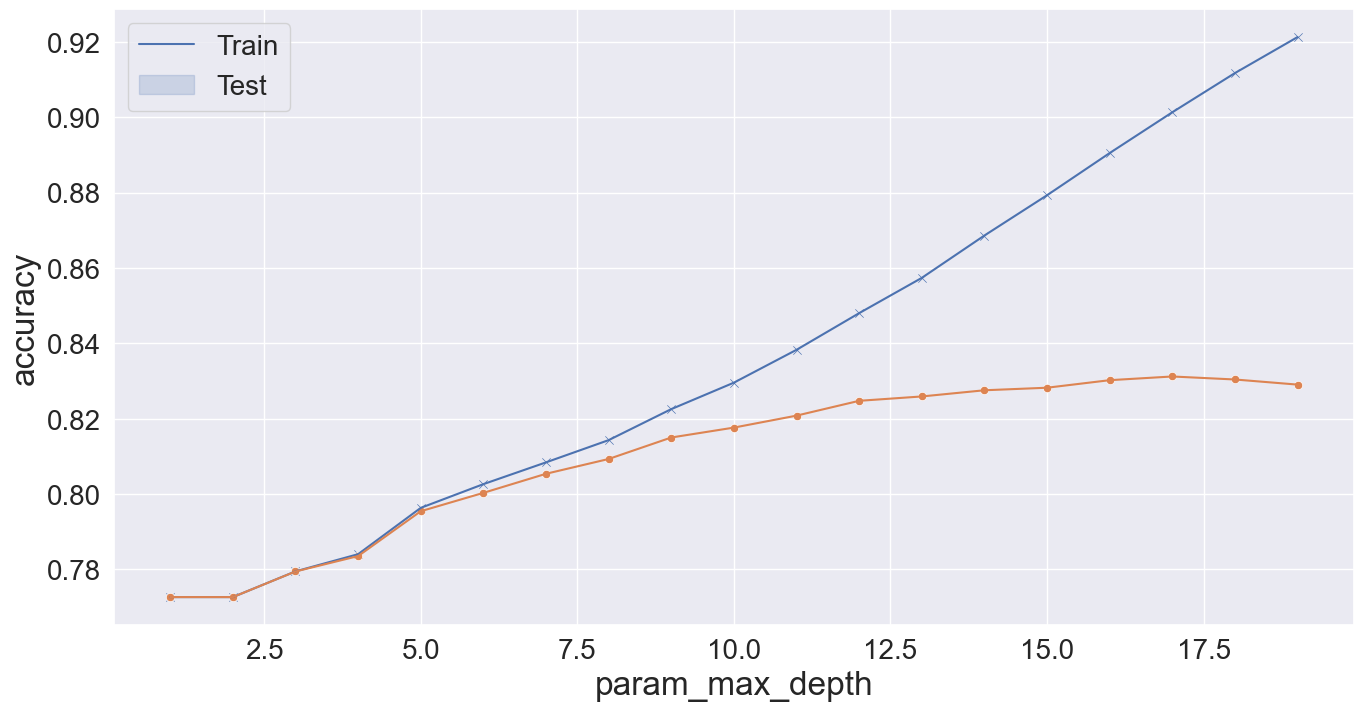

In [ ]:
plot_grid_search_results(gs)
plt.ylabel("accuracy");

We see the test and training accuracy diverges after a tree depth of 8 or so, and the test accuracy plateaus after a tree depth of 15 or so. A relatively good accuracy of around 80% can be achieved. Let's visualize the tree structure.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2)

decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=8)
decision_tree.fit(x_train, y_train)

# We can export this to a graphviz dot file, which can be used to generate a nice plot.
export_graphviz(decision_tree, out_file="metal_insulator_tree.dot", feature_names=list(x.columns))

Let's see what happens when we change the pruning parameter.

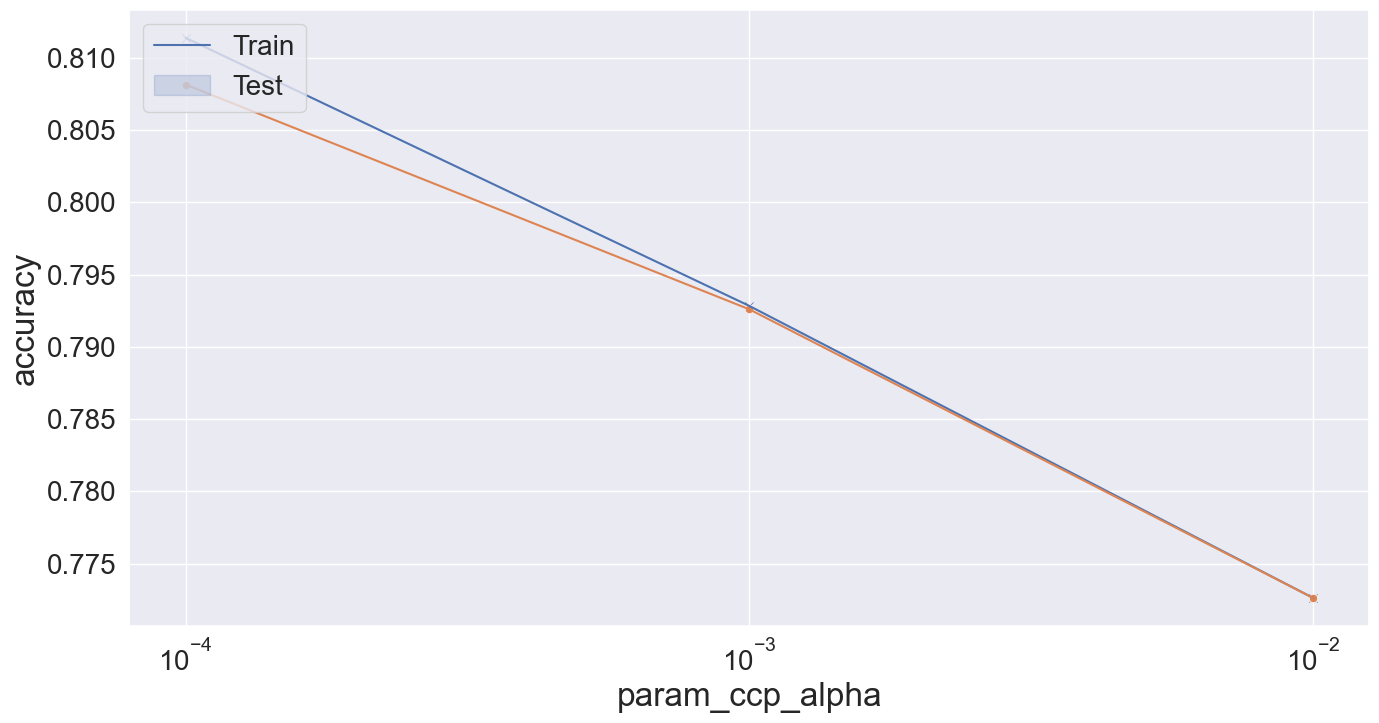

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=8)
gs = GridSearchCV(
    decision_tree,
    param_grid={"ccp_alpha": [1e-4, 1e-3, 1e-2]},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold,
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy")
plt.xscale("log");

As we increase $\alpha$, we decrease the accuracy, but the tree depth decreases.

Let us now visualize a smaller tree to see how decisions are made.

In [ ]:
decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=3)
decision_tree.fit(x_train, y_train)
r = export_text(decision_tree, feature_names=list(x.columns))
print(r)

|--- ColumnMax <= 15.50
|   |--- AtomicRadiusMin <= 0.67
|   |   |--- RowMean <= 2.94
|   |   |   |--- class: 1
|   |   |--- RowMean >  2.94
|   |   |   |--- class: 0
|   |--- AtomicRadiusMin >  0.67
|   |   |--- ElectronegativityMin <= 1.05
|   |   |   |--- class: 0
|   |   |--- ElectronegativityMin >  1.05
|   |   |   |--- class: 0
|--- ColumnMax >  15.50
|   |--- RowMean <= 2.40
|   |   |--- AtomicRadiusMin <= 0.55
|   |   |   |--- class: 1
|   |   |--- AtomicRadiusMin >  0.55
|   |   |   |--- class: 1
|   |--- RowMean >  2.40
|   |   |--- ColumnMin <= 1.50
|   |   |   |--- class: 1
|   |   |--- ColumnMin >  1.50
|   |   |   |--- class: 1



## Feature importance

A very useful of decision trees is that we can visualize the feature importance quite easily.

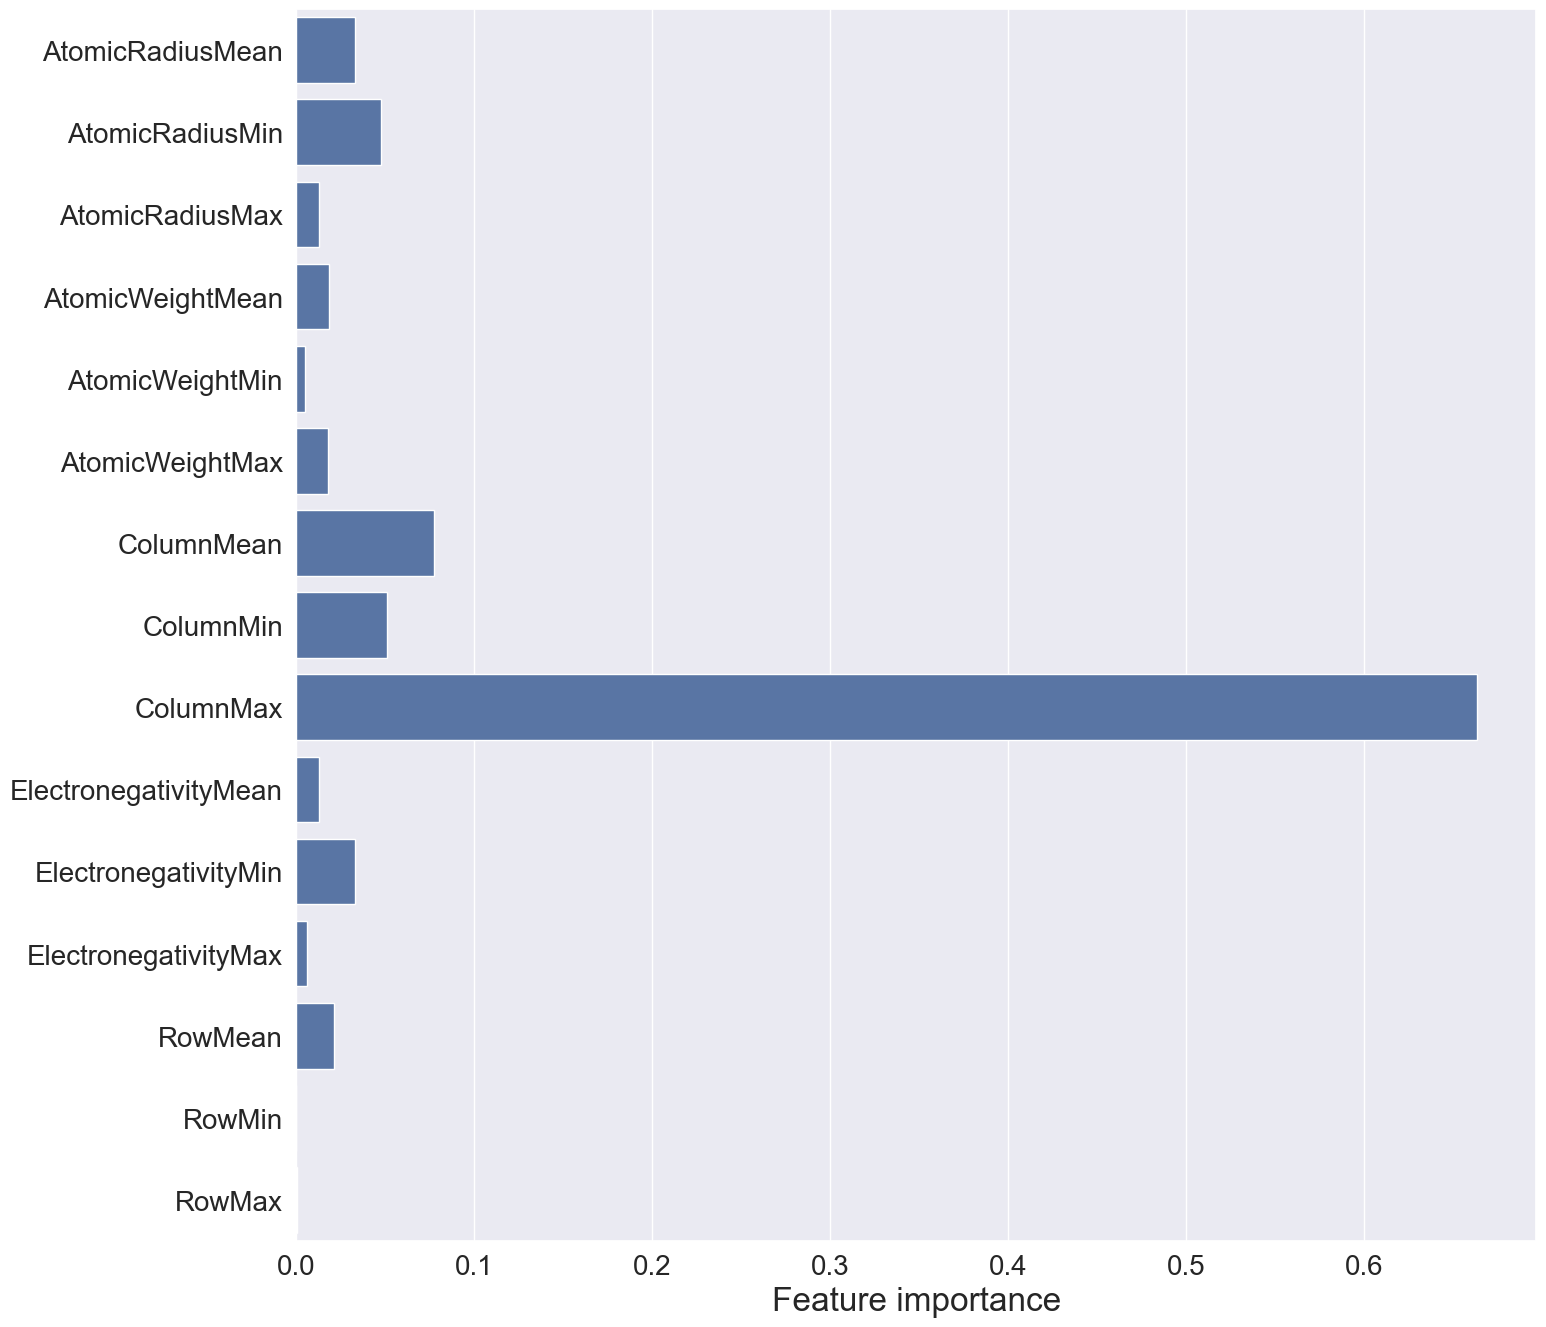

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=8)
decision_tree.fit(x_train, y_train)
plt.subplots(figsize=(16, 16))
sns.barplot(x=decision_tree.feature_importances_, y=list(x.columns), orient="h")
plt.xlabel("Feature importance");

## Receiver Operating Characteristic Curve

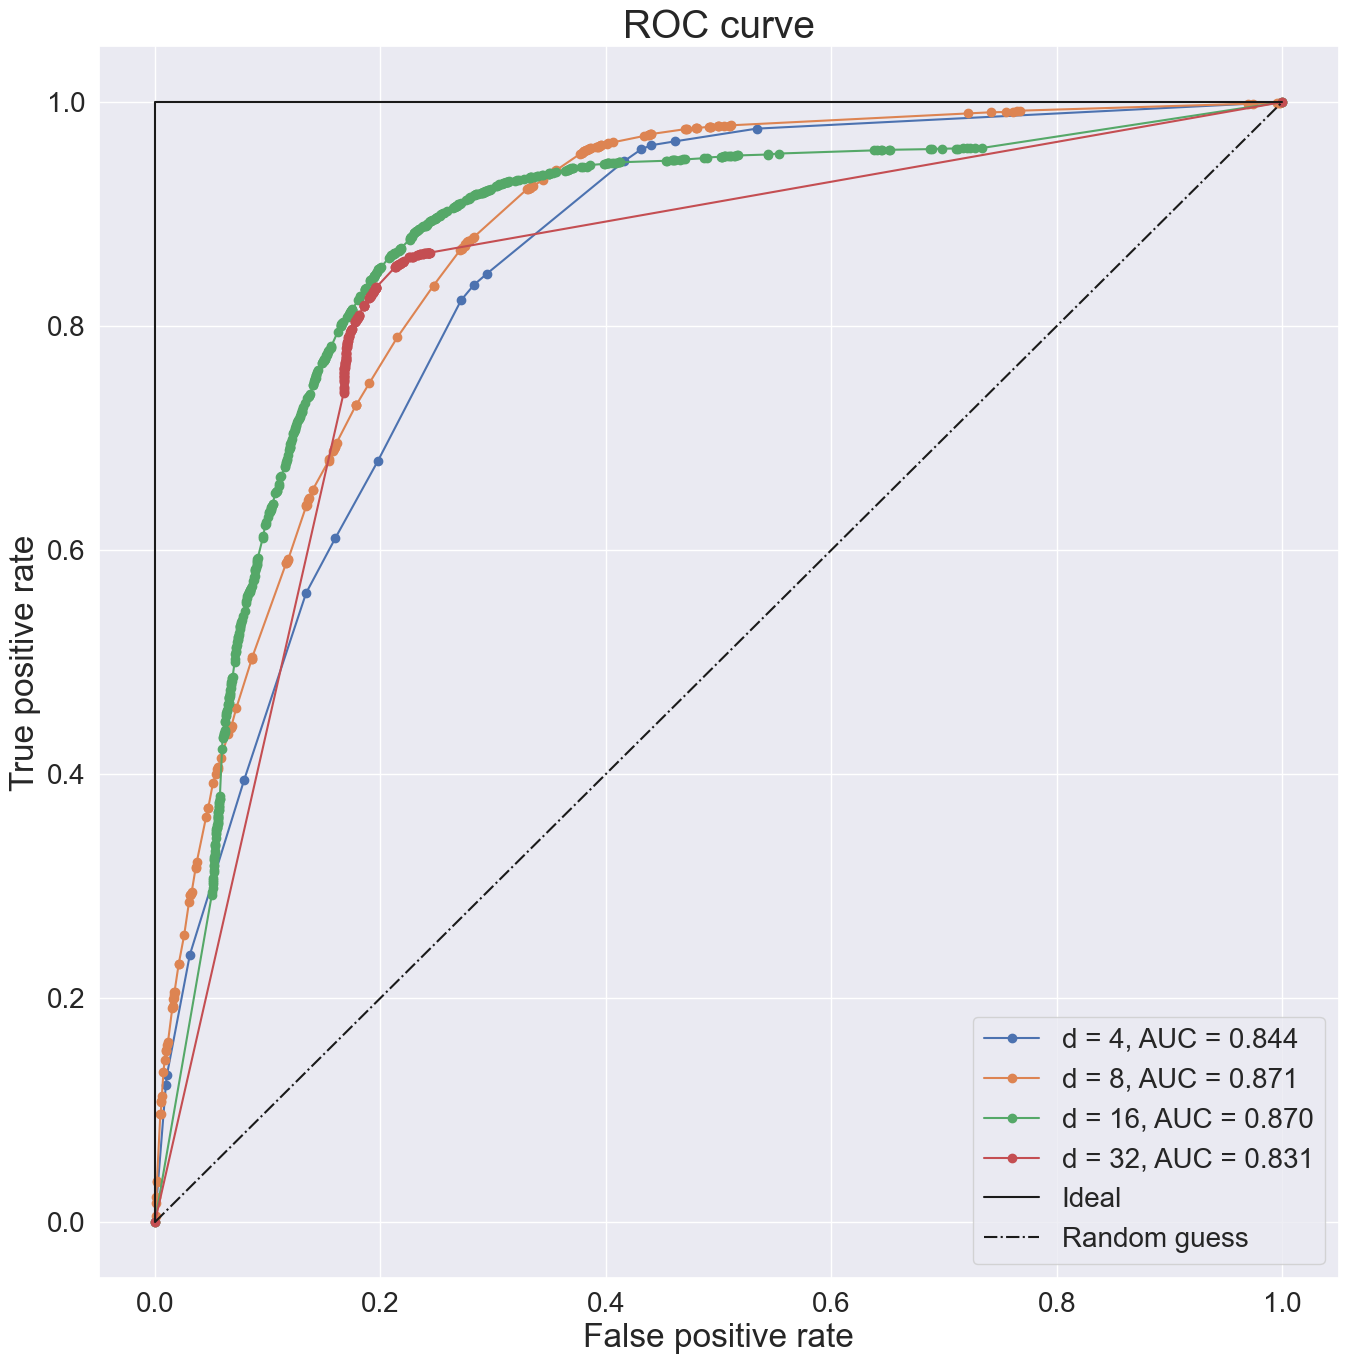

In [ ]:
plt.subplots(figsize=(16, 16))
for d in [4, 8, 16, 32]:
    decision_tree = DecisionTreeClassifier(random_state=0, max_depth=d)
    decision_tree = decision_tree.fit(x_train, y_train)
    train_accuracy = decision_tree.score(x_train, y_train)
    test_accuracy = decision_tree.score(x_test, y_test)

    y_pred = decision_tree.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    a = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, "o-", label=f"d = {d}, AUC = {a:.3f}")

plt.plot([0, 0, 1], [0, 1, 1], "k-", label="Ideal")
plt.plot([0, 1], [0, 1], "k-.", label="Random guess")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend(loc="best");

# Decision Tree Regressor

Instead of just classifying metals and insulators, let us now use the decision tree for regression instead. Here, we will use MSE instead of classification accuracy as the criterion.

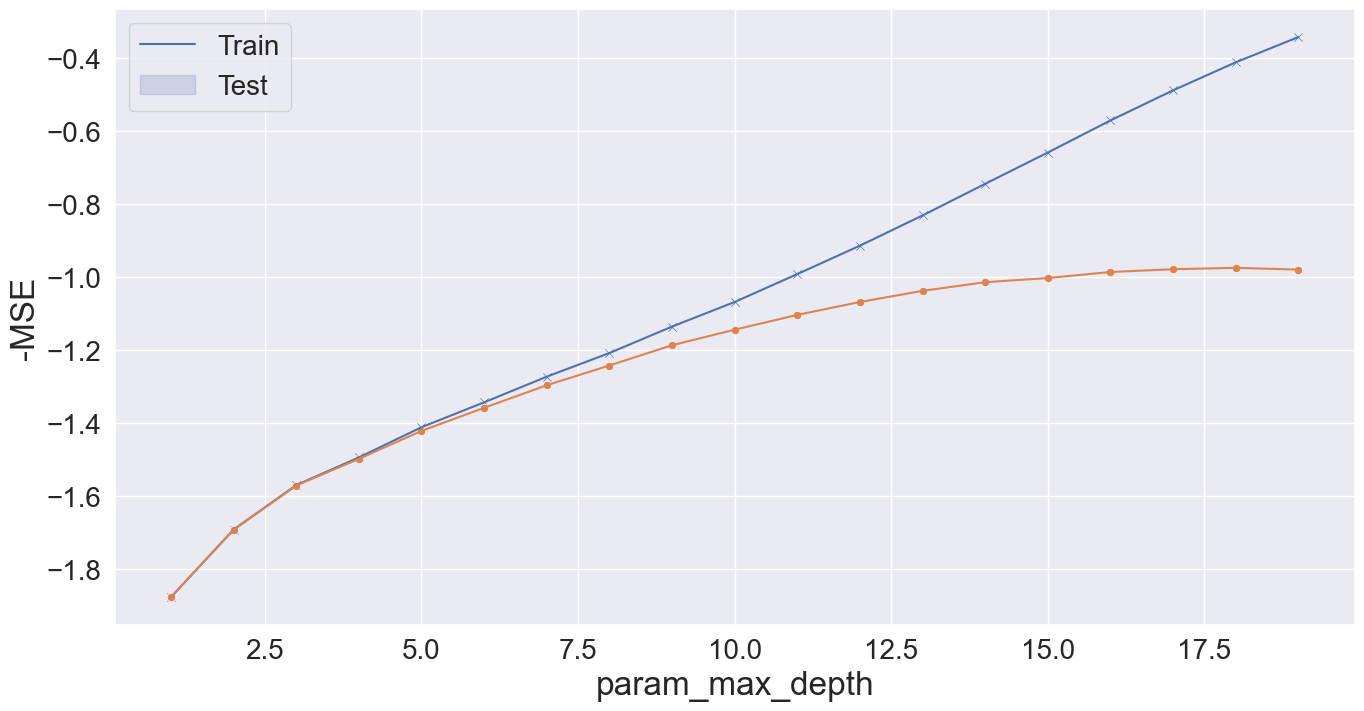

In [ ]:
decision_tree = DecisionTreeRegressor(random_state=0)
gs = GridSearchCV(
    decision_tree,
    param_grid={"max_depth": range(1, 20)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold,
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("-MSE");

We observe that an optimal tree depth of around 15 or so in terms of minimizing MSE. We can achieve a MSE of slightly more than 1 eV. Not great, but reasonable for such a simple model. Let us now explore how alpha affects the tree depth and the MSE.

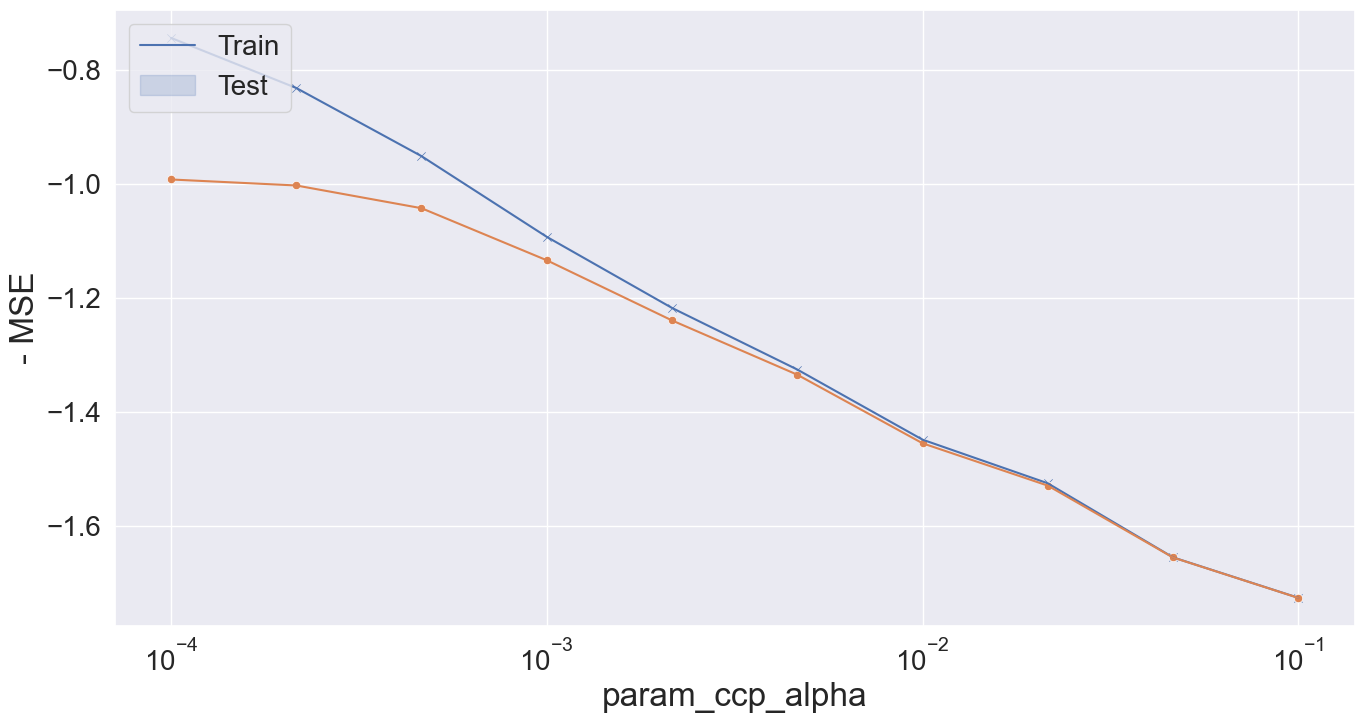

In [ ]:
decision_tree = DecisionTreeRegressor(criterion="squared_error", random_state=0, max_depth=15)

gs = GridSearchCV(
    decision_tree,
    param_grid={"ccp_alpha": np.logspace(-4, -1, 10)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold,
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("- MSE")
plt.xscale("log");

As we increase $\alpha$, we get a simpler (shallower) tree, but the MSE increases. However, the training and test error converges and we get less overfitting.

Let's look at a relatively small tree.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_reg, test_size=0.2)

decision_tree = DecisionTreeRegressor(criterion="squared_error", random_state=0, max_depth=15, ccp_alpha=0.01)
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r = export_text(decision_tree, feature_names=list(x.columns))
print(f"MSE = {mse:.3f}")
print(r)

MSE = 1.454
|--- ElectronegativityMax <= 2.62
|   |--- RowMean <= 1.99
|   |   |--- value: [3.55]
|   |--- RowMean >  1.99
|   |   |--- ColumnMax <= 15.50
|   |   |   |--- value: [0.05]
|   |   |--- ColumnMax >  15.50
|   |   |   |--- value: [0.66]
|--- ElectronegativityMax >  2.62
|   |--- AtomicWeightMax <= 46.41
|   |   |--- AtomicRadiusMin <= 0.55
|   |   |   |--- value: [4.18]
|   |   |--- AtomicRadiusMin >  0.55
|   |   |   |--- value: [2.72]
|   |--- AtomicWeightMax >  46.41
|   |   |--- AtomicRadiusMin <= 0.55
|   |   |   |--- AtomicWeightMax <= 64.46
|   |   |   |   |--- AtomicWeightMean <= 27.38
|   |   |   |   |   |--- value: [1.87]
|   |   |   |   |--- AtomicWeightMean >  27.38
|   |   |   |   |   |--- value: [0.59]
|   |   |   |--- AtomicWeightMax >  64.46
|   |   |   |   |--- value: [2.61]
|   |   |--- AtomicRadiusMin >  0.55
|   |   |   |--- ElectronegativityMin <= 0.94
|   |   |   |   |--- value: [1.69]
|   |   |   |--- ElectronegativityMin >  0.94
|   |   |   |   |--- 

# Ensemble Learning

Here, we are going to look at some ensemble learning approaches to improve the predictions of decision trees for both classification and regression. To demonstrate the impact more clearly, we will use relatively shallow trees of `max_depth=8` for classification and `max_depth=15` for regression throughout.

In [ ]:
max_depth_class = 3
max_depth_reg = 15

## Adaboost

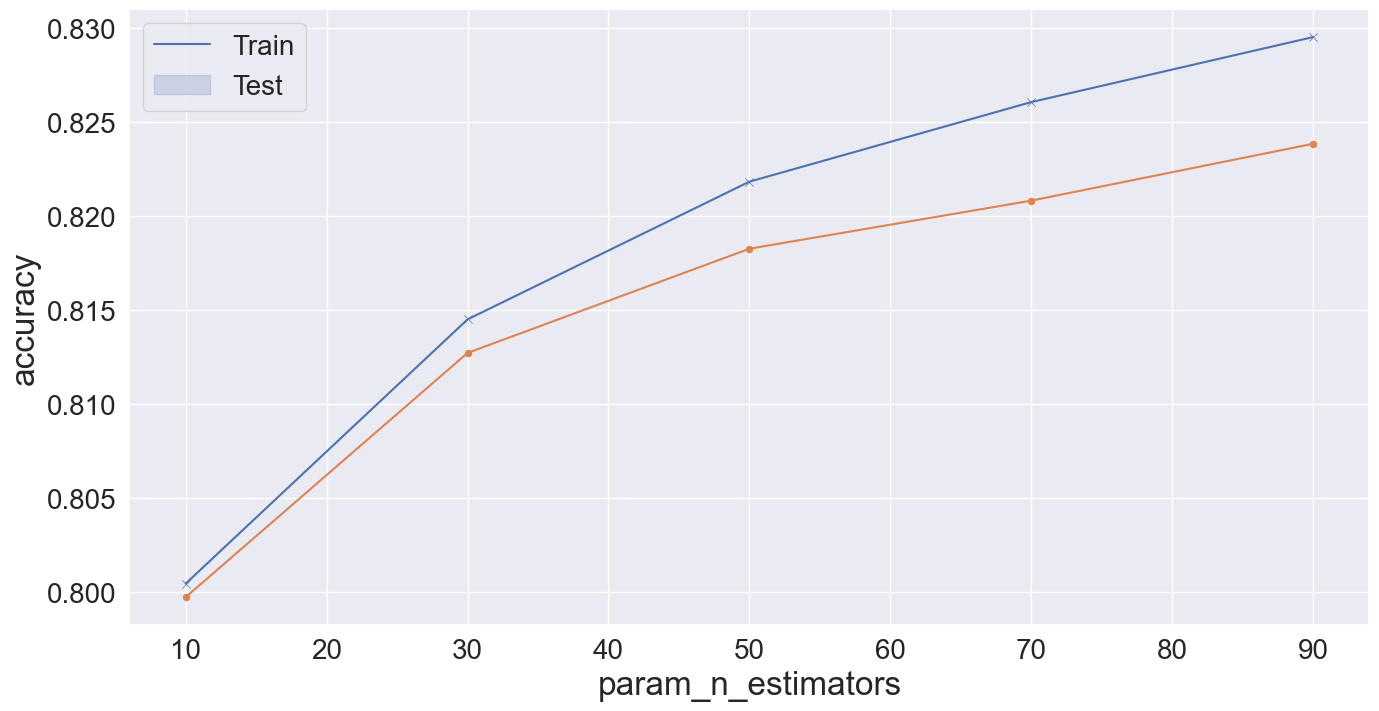

In [ ]:
model = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=max_depth_class))

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(10, 100, 20)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold,
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

We can see that even with a small tree, boosting allows us to achieve higher classification accuracies. There is some evidence of overfitting, as can be seen from the divergence of the training and test accuracies. We can of course play around with the tree depth as well as the learning rate to improve the results.

For regression, we will use a decision tree with a max depth of 15 and a lower learning rate.

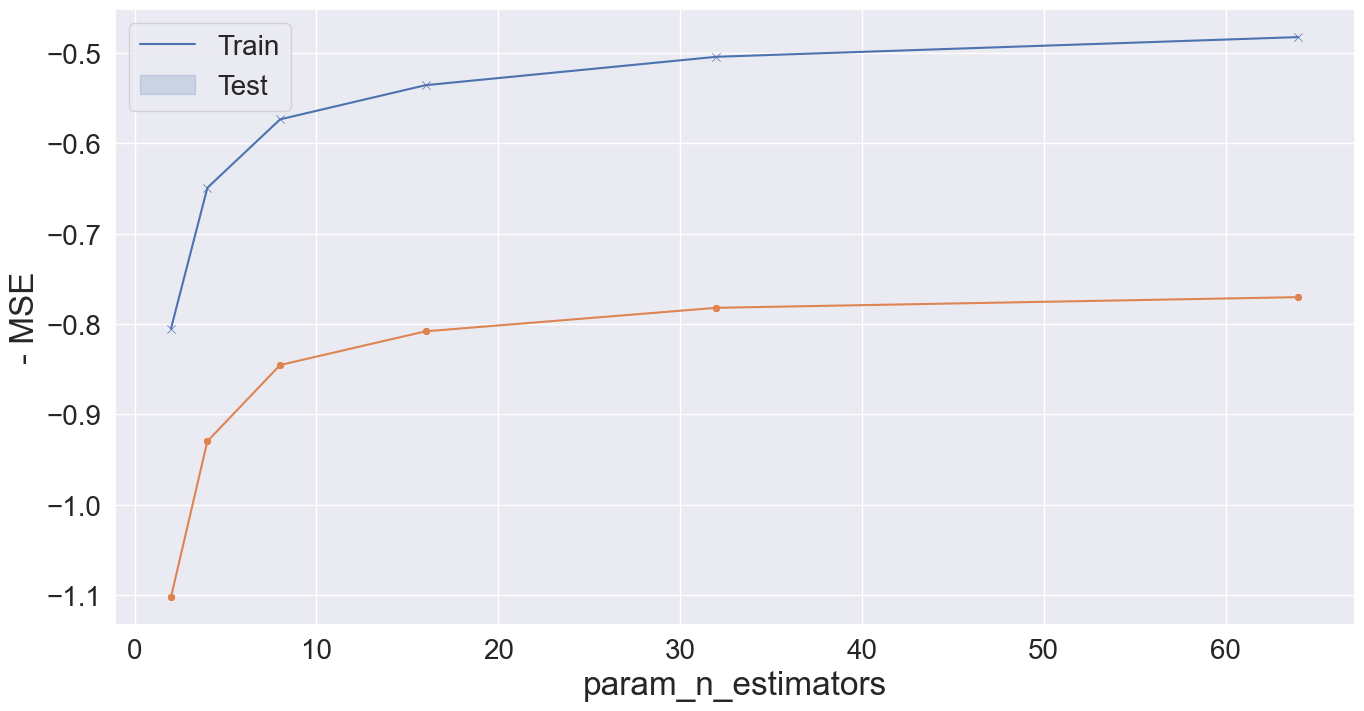

In [ ]:
model = AdaBoostRegressor(DecisionTreeRegressor(random_state=0, max_depth=max_depth_reg), learning_rate=0.1)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": [2, 4, 8, 16, 32, 64]},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold,
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("- MSE");

We can see that we can get to a substantially lower test MSE of 0.85 eV or so with boosting, albeit with some evidence of over-fitting.

## Gradient boosting

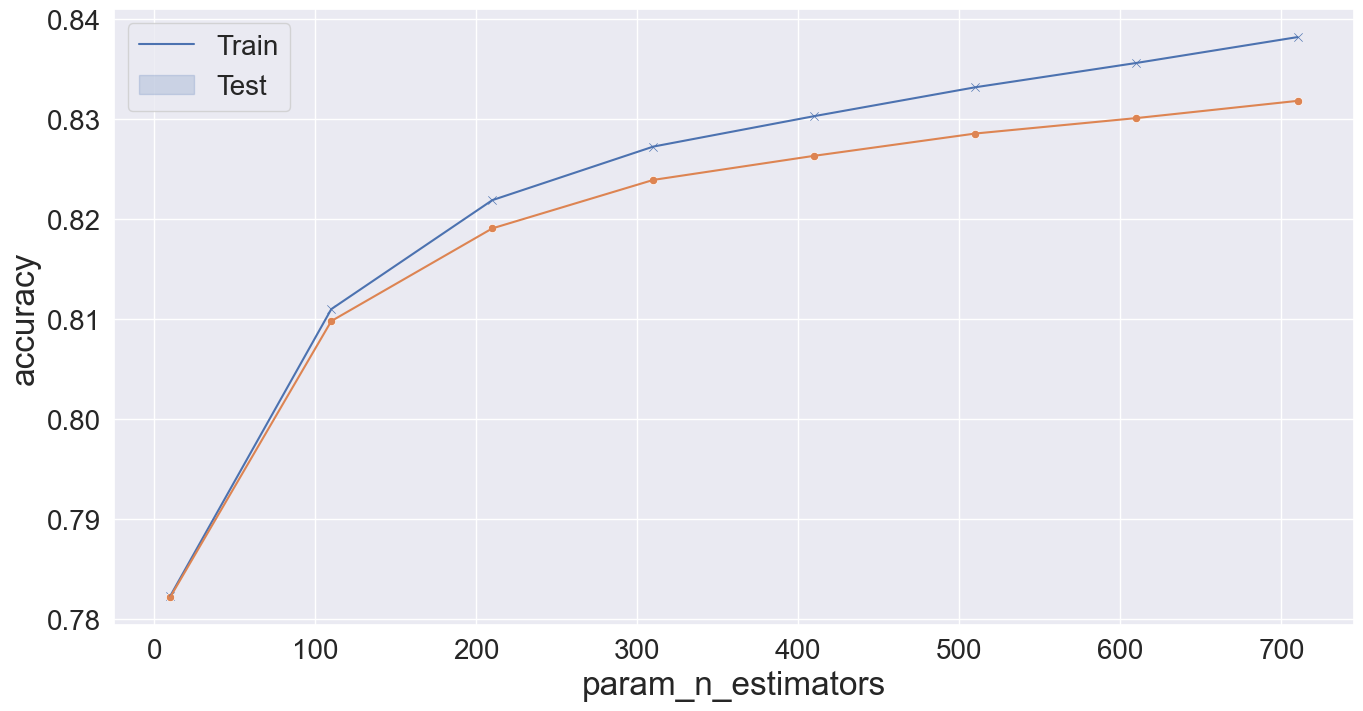

In [ ]:
model = GradientBoostingClassifier(random_state=0, max_depth=max_depth_class)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(10, 800, 100)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold,
    n_jobs=4,
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

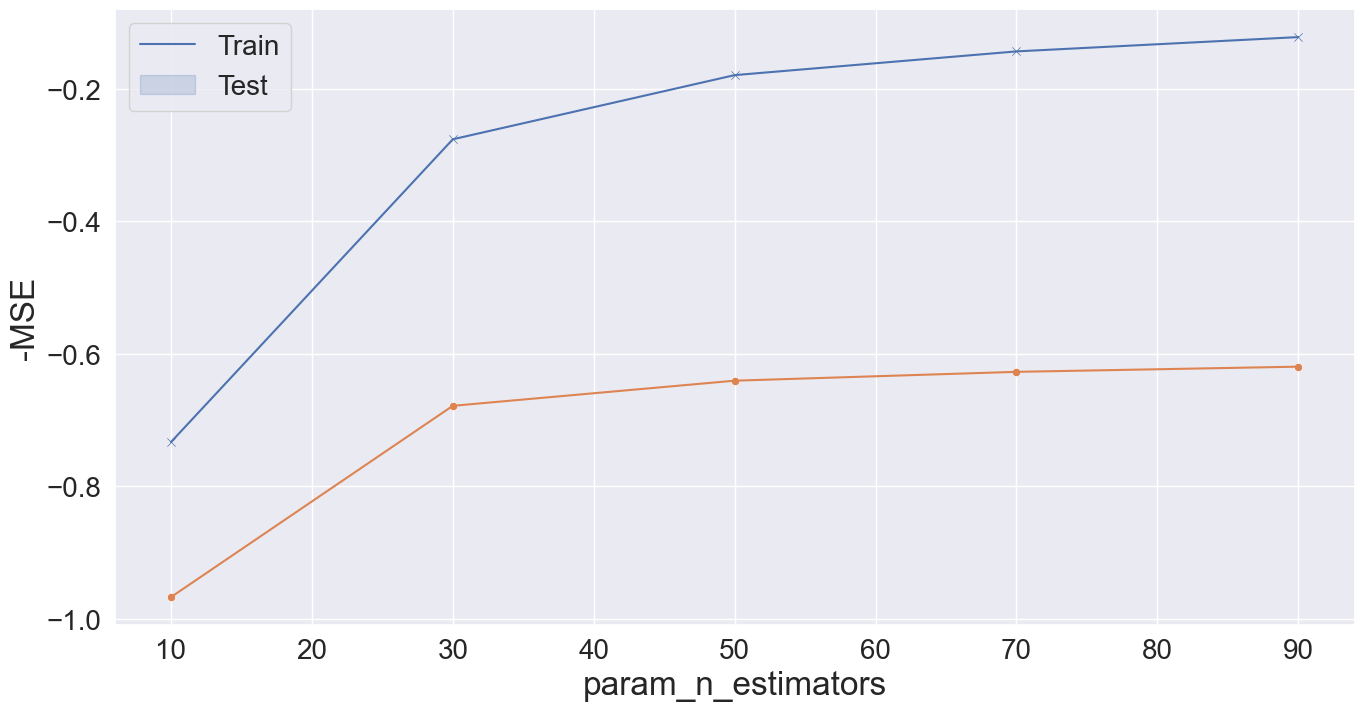

In [ ]:
model = GradientBoostingRegressor(random_state=0, max_depth=max_depth_reg)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(10, 100, 20)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold,
    n_jobs=4,
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("-MSE");

## Random Forests

We will now lookn at random forest models for performing the same classificaiton and regression tasks. For classification, we will first use the same maximum tree depth as before of 3.

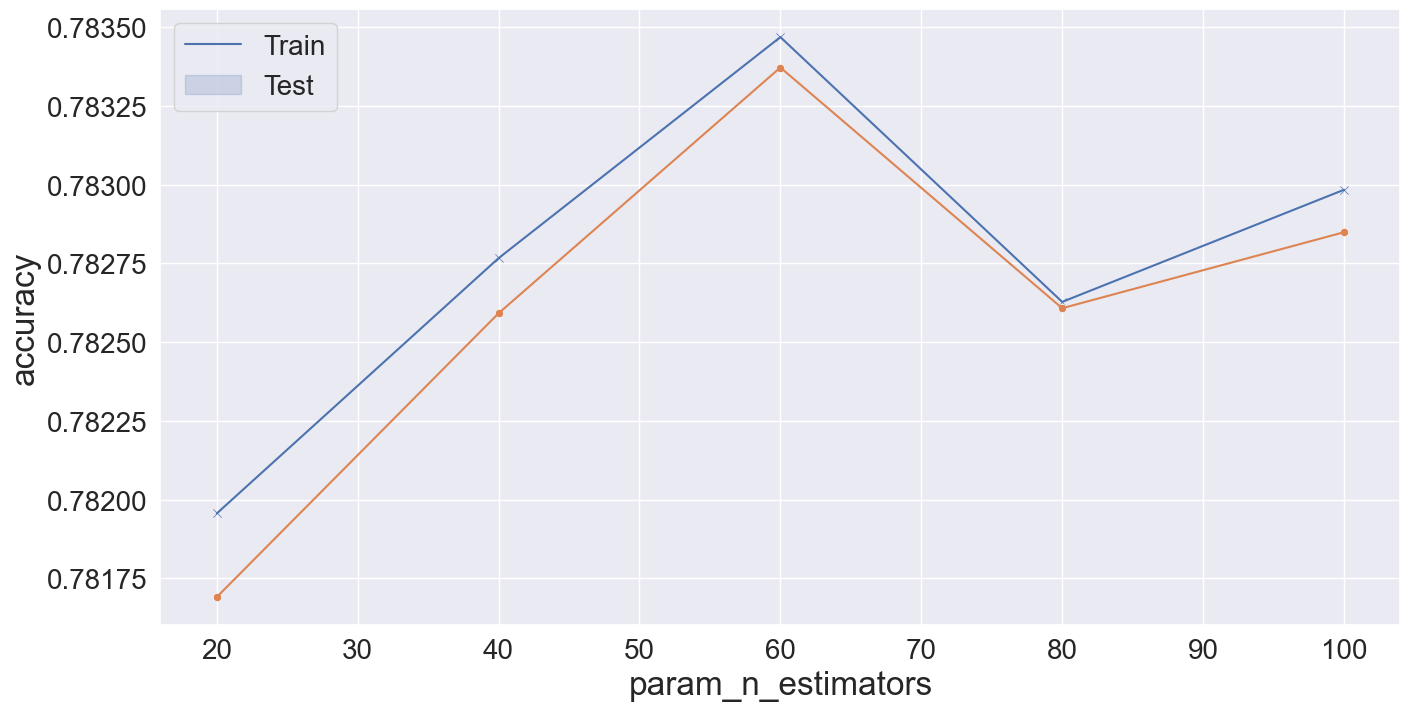

In [ ]:
model = RandomForestClassifier(random_state=0, max_depth=max_depth_class)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(20, 120, 20)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold,
    n_jobs=4,
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

We see that with a maximum depth of 3, there is very little overfitting, but the performance is somewhat lower that what we have achieved with gradient boosting.

Let us now remove all variables and let the default implementation try to find the optimal random forest model.

/Users/shyue/miniconda3/envs/mavrl/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


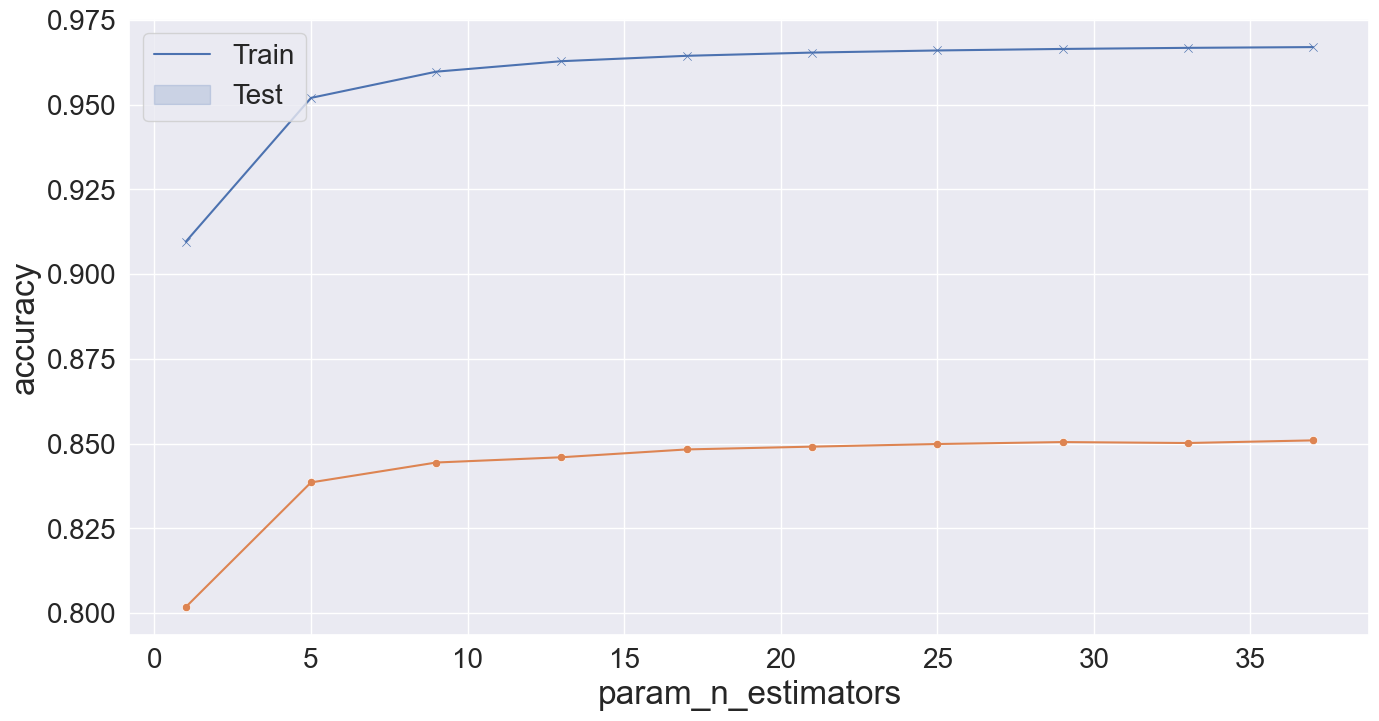

In [ ]:
model = RandomForestClassifier(random_state=0)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(1, 40, 4)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold,
    n_jobs=4,
)
gs.fit(x, y_class)
plot_grid_search_results(gs)
plt.ylabel("accuracy");

We see that the performance has substantially improved for both training and test data, but there is evidence of significant overfitting!

We can gain some insights into how the random forest is getting this performance by looking at the feature importances. 

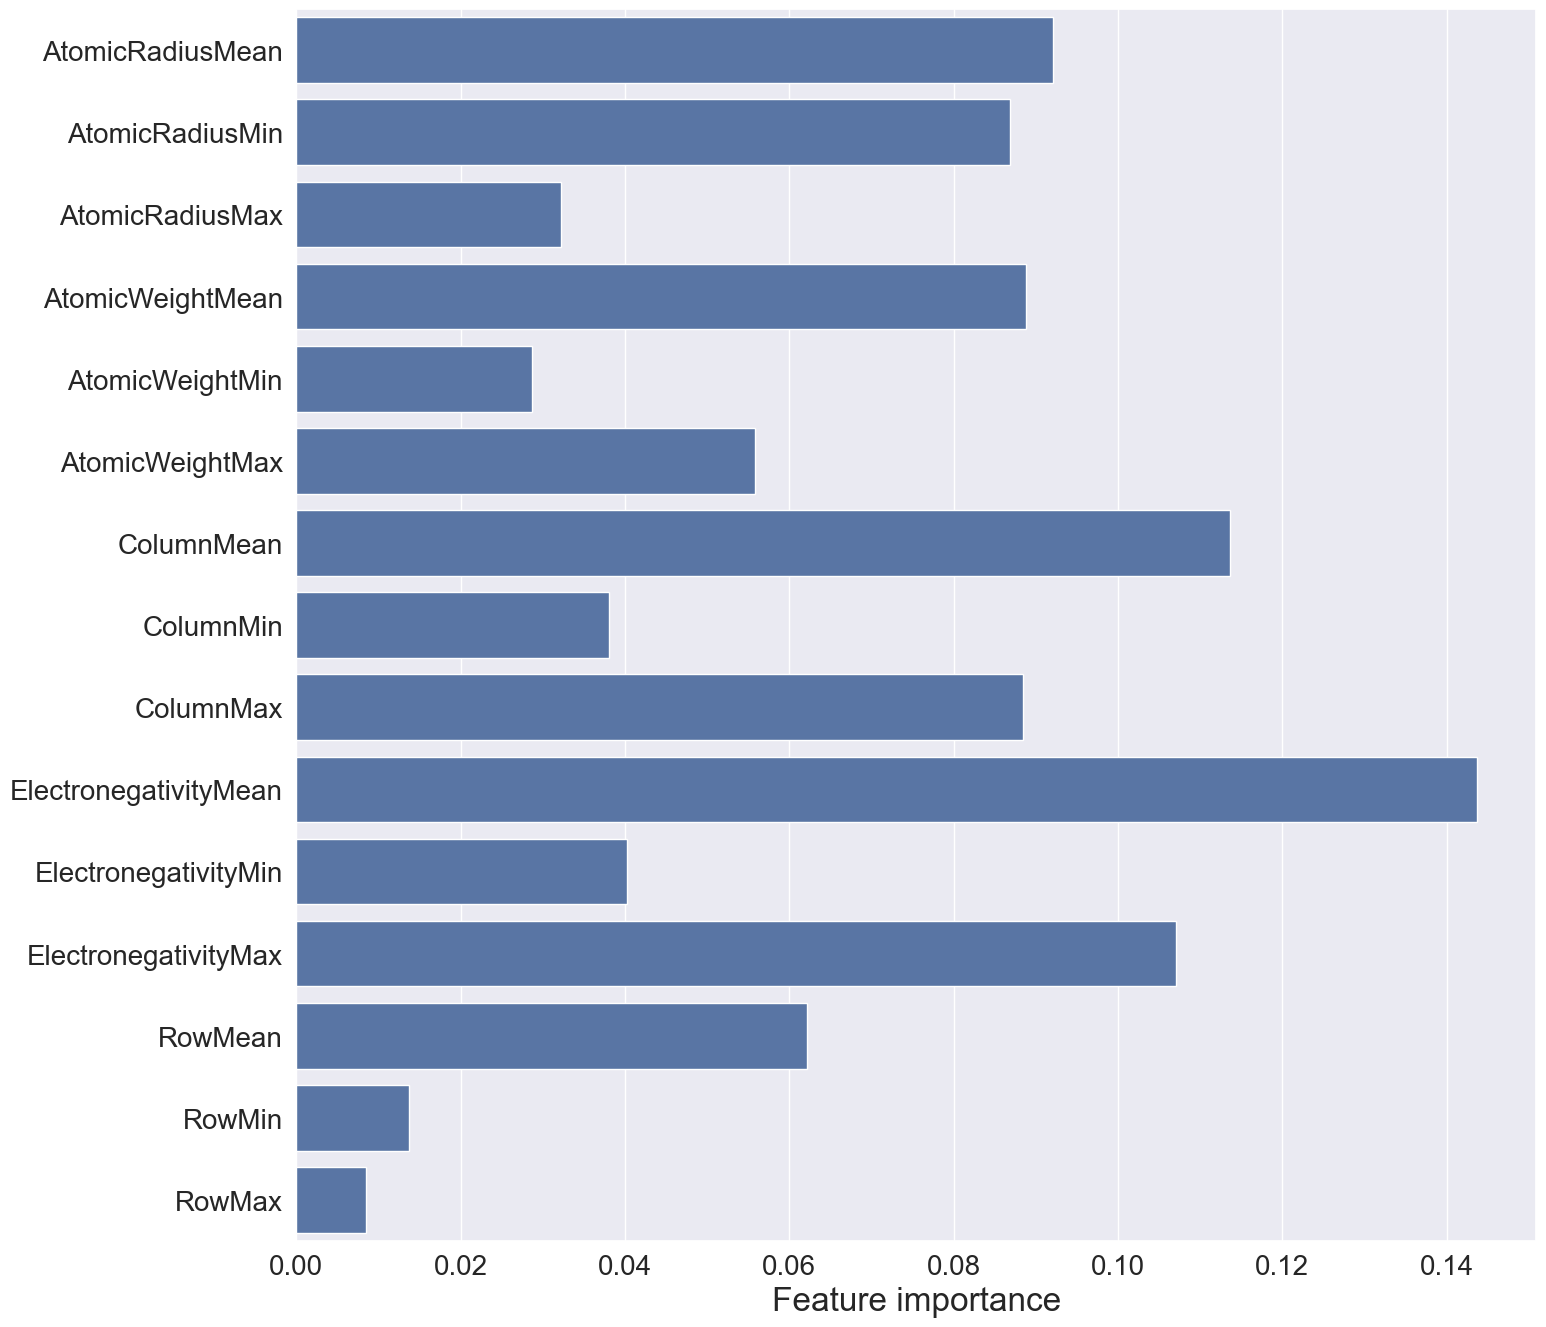

In [ ]:
model = RandomForestClassifier(random_state=0, n_estimators=20)
model.fit(x, y_class)
plt.subplots(figsize=(16, 16))
sns.barplot(x=model.feature_importances_, y=list(x.columns), orient="h")
plt.xlabel("Feature importance");

We will now look at the random forest for the regression task.

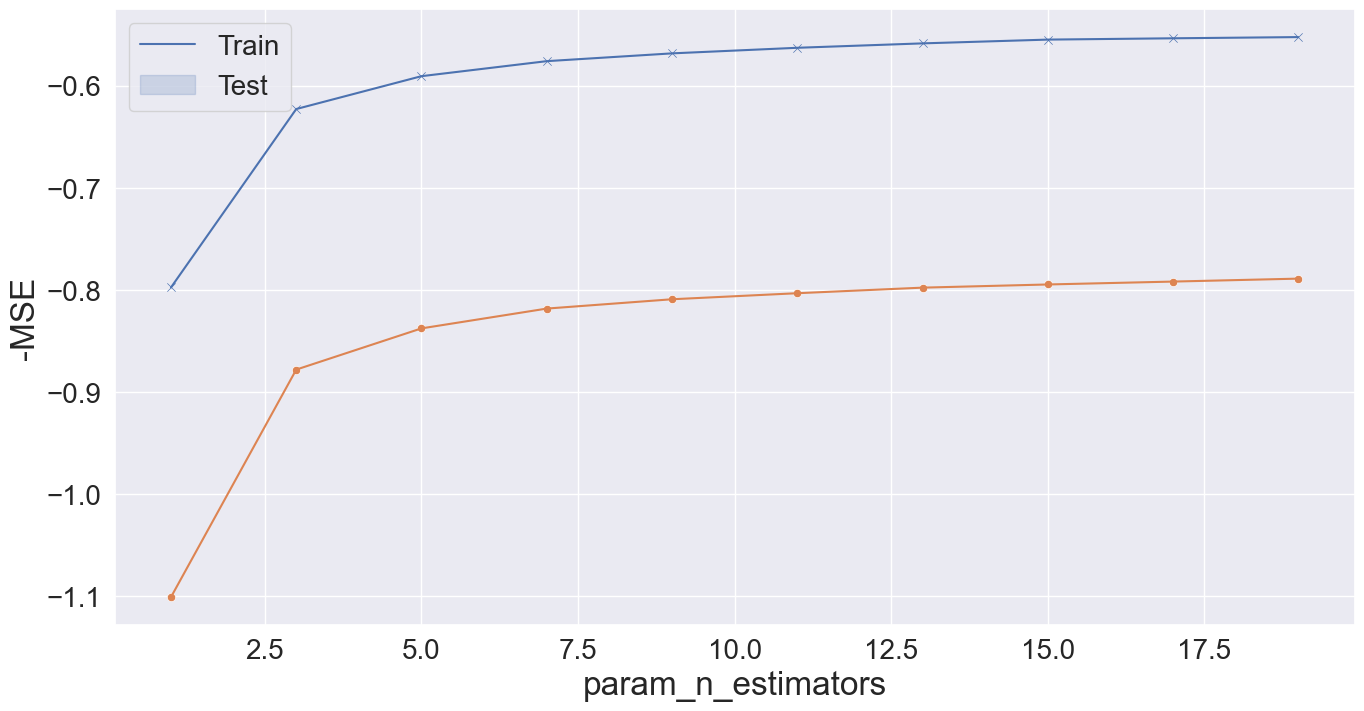

In [ ]:
model = RandomForestRegressor(random_state=0, max_depth=max_depth_reg)

gs = GridSearchCV(
    model,
    param_grid={"n_estimators": range(1, 20, 2)},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold,
    n_jobs=8,
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("-MSE");

With the same max depth, we see that the performance has substantially improved. A test MSE of < 1eV is now possible but again, we see quite a bit of overfitting. Let's try to gain some insight into the base decision tree being used with 10 estimators.

While you can try to further tweak he model by setting parameters like `min_samples leaf`, a simpler approach is to just let the algorithm automatically prune the tree by setting the $\alpha$ parameter.

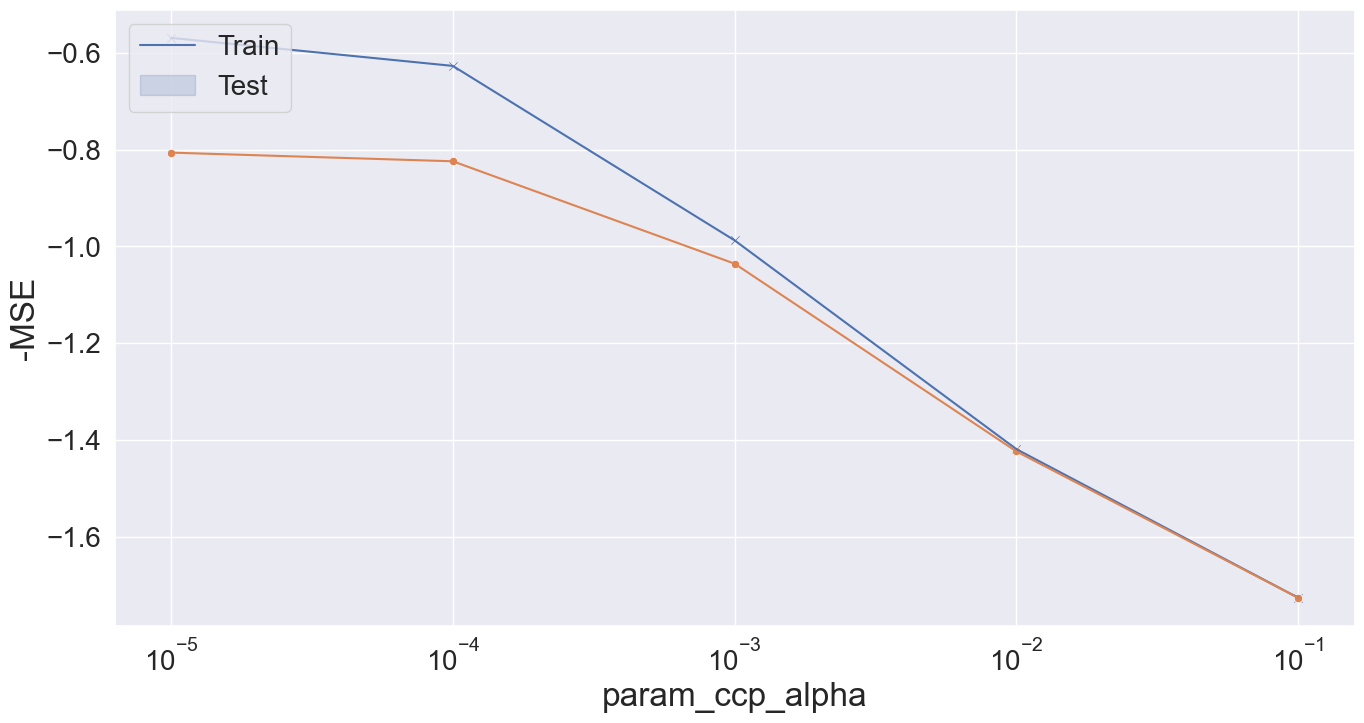

In [ ]:
model = RandomForestRegressor(random_state=0, max_depth=15, n_estimators=10)

gs = GridSearchCV(
    model,
    param_grid={"ccp_alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold,
    n_jobs=8,
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)
plt.ylabel("-MSE")
plt.xscale("log")

Quite clearly, there is a tradeoff between tree complexity, MSE and overfitting. At high $\alpha > 1e-3$, there is minimal overfitting but the best we can do is an MSE of around 1.2 eV or more. The less the overfitting, the more confidence we have about the model being generalizable to future unseen data.